Return to Live Ocean Files and see if we can do better

In [86]:
import cmocean.cm as cm
import datetime
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as Basemap
import netCDF4 as nc
import numpy as np
import os
import scipy.interpolate as sinter
import xarray as xr

from salishsea_tools import LiveOcean_grid as grid
from salishsea_tools import gsw_calls
from salishsea_tools import LiveOcean_BCs as nancy

%matplotlib inline

# Define some stuff

In [87]:
var_meta = {'vosaline': {'grid': 'SalishSea2',
                             'long_name': 'Practical Salinity',
                             'units': 'psu'},
                'votemper': {'grid': 'SalishSea2',
                             'long_name': 'Potential Temperature',
                             'units': 'deg C'}
                }


LO_to_NEMO_var_map = {'salt': 'vosaline',
                          'temp': 'votemper',
                     'NO3': 'NO3'}

# Initialize var_arrays dict
NEMO_var_arrays = {key: [] for key in LO_to_NEMO_var_map.values()}

    

# Load BC information
    depBC, lonBC, latBC, shape = load_SalishSea_boundary_grid(fname=NEMO_BC)

# Specify the (New) Boundary Grid

In [88]:
# this replace's Nancy's function load_SalishSea_boundary_grid
imin = 381 - 1  # want 380  # have 381
imax = 467 # want 470 # have 467
rim = 10

with nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as meshfile:

    lonBC = meshfile.variables['nav_lon'][imin:imax, 0:rim]
    latBC = meshfile.variables['nav_lat'][imin:imax, 0:rim]
    mbathy = meshfile.variables['mbathy'][0, imin:imax, 0:rim]
    gdepw = meshfile.variables['gdepw_0'][0, :, imin:imax, 0:rim]
    surface_tmask = meshfile.variables['tmask'][0, 0, imin:imax, 0:rim]
    tmask = meshfile.variables['tmask'][0, :, imin:imax, 0:rim]
    depBC = meshfile.variables['gdept_1d'][0]

surface_tmask = np.abs(surface_tmask - 1)
tmask = tmask -1
shape = lonBC.shape

NEMO_depth = np.zeros(shape)
for i in range(shape[1]):
    for j in range(shape[0]):
        level = mbathy[j, i]
        NEMO_depth[j, i] = gdepw[level, j, i]
NEMO_raw = np.copy(NEMO_depth)
NEMO_depth = np.ma.masked_array(NEMO_depth, mask=surface_tmask)

# Get the Live Ocean File

In [89]:
# this replaces Nancy's load_LiveOcean
LO_dir='/results/forcing/LiveOcean/downloaded/'
start = '2017-12-27'
sdt = datetime.datetime.strptime(start, '%Y-%m-%d')
file = os.path.join(LO_dir, sdt.strftime('%Y%m%d'), 'low_passed_UBC.nc')
print(file)

G, S, T = grid.get_basic_info(file)

print (G.keys())
print (S.keys())
print (T.keys())

/results/forcing/LiveOcean/downloaded/20171227/low_passed_UBC.nc
dict_keys(['h', 'lon_u', 'lon_rho', 'mask_rho', 'lon_v', 'pm', 'M', 'mask_v', 'pn', 'mask_u', 'lat_u', 'DX', 'DY', 'L', 'lat_rho', 'lat_v'])
dict_keys(['N', 'Cs_r', 'Vtransform', 's_rho', 'hc'])
dict_keys(['ocean_time', 'time'])


In [90]:
d = xr.open_dataset(file)
zeta = d.zeta.values[0]
z_rho = grid.get_z(G['h'], zeta, S)
zrho_DA = xr.DataArray(
    np.expand_dims(z_rho, 0),
    dims=['ocean_time', 's_rho', 'eta_rho', 'xi_rho'],
        coords={'ocean_time': d.ocean_time.values[:],
                's_rho': d.s_rho.values[:],
                'eta_rho': d.eta_rho.values[:],
                'xi_rho': d.xi_rho.values[:]},
        attrs={'units': 'metres',
               'positive': 'up',
               'long_name': 'Depth at s-levels',
               'field': 'z_rho ,scalar'})
d = d.assign(z_rho=zrho_DA)

# Process Live Ocean File

## Depth Interpolation

In [91]:
var_names = ['salt', 'temp', 'NO3']
dataset = d
interps = {}
for var_name in var_names:
    var_interp = np.zeros(dataset[var_name][0].shape)
    for j in range(var_interp.shape[1]):
        for i in range(var_interp.shape[2]):
            LO_depths = dataset.z_rho.values[0, :, j, i]
            var = dataset[var_name].values[0, :, j, i]
            var_interp[:, j, i] = np.interp(
                -depBC, LO_depths, var, left=np.nan)
            # NEMO depths are positive, LiveOcean are negative
    interps[var_name] = np.ma.masked_invalid(var_interp)
print(interps['salt'].shape)

(40, 31, 26)


In [92]:
lonsLO = dataset.lon_rho.values[0, :]
latsLO = dataset.lat_rho.values[:, 0]

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(lonsLO, latsLO, interps['salt'][0], cmap=cm.haline)
ax.pcolormesh(lonBC, latBC, 1-tmask[0], cmap='copper')

## Convert to TEOS-10

In [93]:
var_meta, interps['salt'], interps['temp'] = \
            nancy._convert_TS_to_TEOS10(
                var_meta, interps['salt'], interps['temp'])

## Remove South of Tatoosh

In [94]:
for var in var_names:
    for i in range(6):
        for j in range(17):
            interps[var][:, i, j] = np.nan

    interps[var] = np.ma.masked_invalid(interps[var][:])

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['NO3'][i+j*5], vmax=40, vmin=0)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['temp'][i+j*5], cmap=cm.haline)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

## Fill

In [95]:
for var in var_names:
    for k in range(35):
        array = np.ma.masked_invalid(interps[var][k])
        xx, yy = np.meshgrid(range(26), range(31))
        x1 = xx[~array.mask]
        y1 = yy[~array.mask]
        newarr = array[~array.mask]
        interps[var][k] = sinter.griddata((x1, y1), newarr.ravel(),
                         (xx, yy), method='nearest')

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['salt'][i+j*5], cmap=cm.haline, vmax=34.5, vmin=30)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(7):
    for j in range(7):
        axs[j, i].pcolormesh(interps['temp'][i+j*5], cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].text(20, 23, str(i+j*5))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)

## Convect

In [96]:
sigma = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interps['salt'][:], interps['temp'][:] ])

In [97]:
def convect(sigma, interps, var_names):
    kmax, imax, jmax = sigma.shape
    good = False
    while not good:
        print('Loop')
        good = True
        for k in range(kmax - 1):
            for i in range(imax):
                for j in range(jmax):
                    if sigma[k, i, j] > sigma[k + 1, i, j]:
                        good = False
                        for var in var_names:
                            interps[var][k, i, j], interps[var][
                                k + 1, i, j] = interps[var][
                                    k + 1, i, j], interps[var][k, i, j]
                        sigma[k, i, j], sigma[k + 1, i, j] = sigma[
                            k + 1, i, j], sigma[k, i, j]
    return sigma, interps

In [98]:
sigma, interps = convect(sigma, interps, var_names)

Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop


columns = 7
rows = 5
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interps['salt'][i+j*columns], cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].text(20, 23, str(i+j*columns))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)
print(np.mean(interps['salt'][0]))
print(np.mean(interps['salt'][15]))
print(np.mean(interps['salt'][30]))


columns = 7
rows = 5
fig, axs = plt.subplots(rows, columns, figsize=(20, 20))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interps['temp'][i+j*columns], cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].text(20, 23, str(i+j*columns))
        axs[j, i].set_xlim(0, 26)
        axs[j, i].set_ylim(0, 31)
print(np.mean(interps['temp'][0]))
print(np.mean(interps['temp'][15]))
print(np.mean(interps['temp'][30]))

fig, ax = plt.subplots(1, 1)
mesh = ax.pcolormesh(sigma[:-1, :, 5] - sigma[1:, :, 5], vmin=-2, vmax=2, cmap='bwr')
fig.colorbar(mesh)
ax.invert_yaxis()
print(np.nanmax(sigma[:-1, :, :] - sigma[1:, :, :]))

## Extend to Depth

In [99]:
for var in var_names:
    interps[var][35:] = interps[var][34]

## Interpolate Horizontally onto NEMO grid

In [100]:
interpl = {}
for var in var_names:
    var_new = np.zeros((interps[var].shape[0], shape[0], shape[1]))
    for k in range(var_new.shape[0]):
        var_grid = interps[var][k, :, :]
        var_new[k, ...] = Basemap.interp(
            var_grid, lonsLO, latsLO, lonBC, latBC)
    interpl[var] = var_new

## Convect Again

In [101]:
sigmal = gsw_calls.generic_gsw_caller('gsw_sigma0.m', [interpl['salt'][:], interpl['temp'][:] ])

In [102]:
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))
sigmal, interpl = convect(sigmal, interpl, var_names)
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))

0.001
Loop
Loop
Loop
Loop
Loop
Loop
Loop
Loop
0.0


rows, columns = 4, 10
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(interpl['salt'][i+j*columns], cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].text(5, 80, str(i+j*columns))
        axs[j, i].set_xlim(0, 10)
        axs[j, i].set_ylim(0, 91)
print(np.mean(interpl['salt'][0]))
print(np.mean(interpl['salt'][15]))
print(np.mean(interpl['salt'][30]))

rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['salt'].shape[1]), -depBC, 
                             np.ma.masked_array(interpl['salt'][:,:,i+j*columns], mask=tmask[:, :, i+j*columns]), cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 91)
print (interpl['salt'].shape)

rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['temp'].shape[1]), -depBC, 
                             np.ma.masked_array(interpl['temp'][:,:,i+j*columns], mask=tmask[:, :, i+j*columns]), cmap=cm.thermal, vmax=9, vmin=7)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 91)
print (interpl['temp'].shape)

0.0


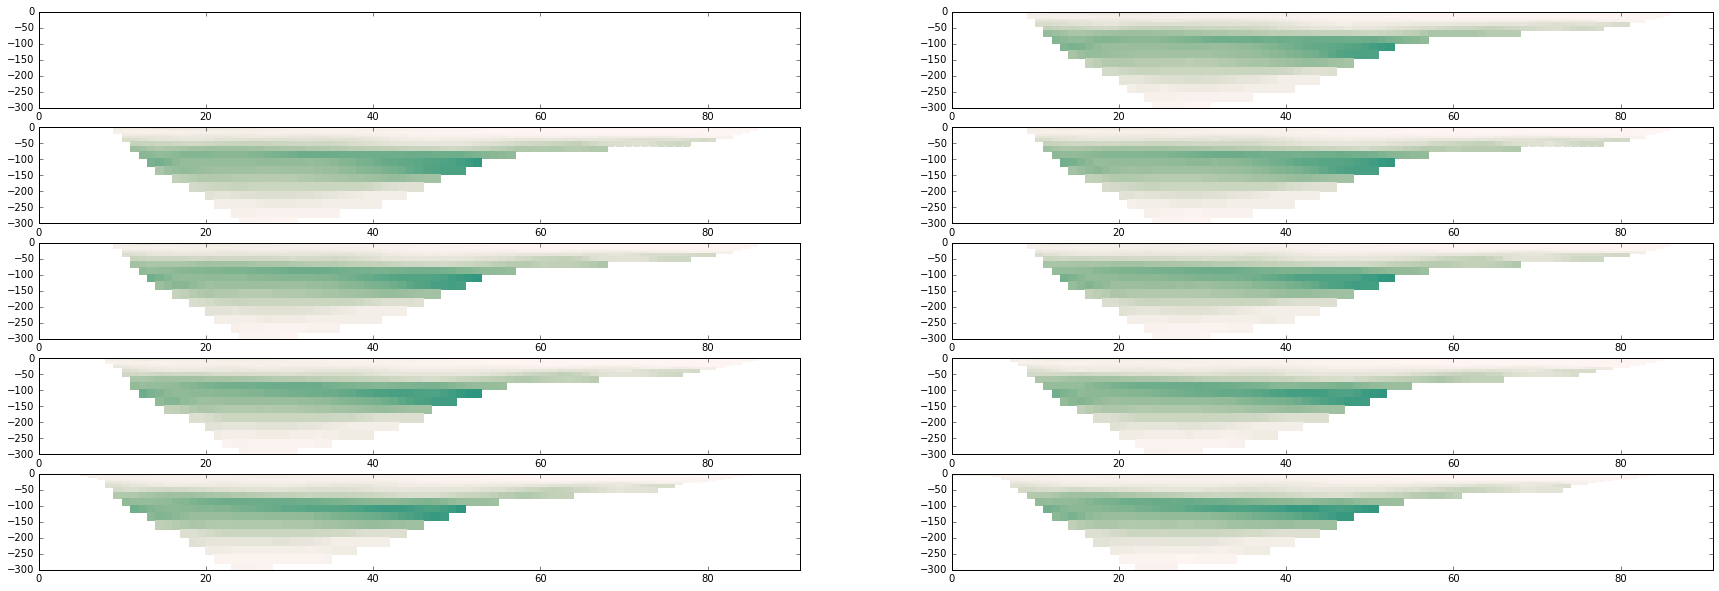

In [103]:
rows, columns = 5, 2
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(sigmal.shape[1]), -depBC[1:], 
                             np.ma.masked_array(sigmal[:-1,:,i+j*columns] - sigmal[1:, :, i+j*columns], 
                                                mask=tmask[1:, :, i+j*columns]), cmap=cm.curl, vmax=1, vmin=-1)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 91)
print(np.nanmax(sigmal[:-1, :, :] - sigmal[1:, :, :]))

rows, columns = 10, 8
fig, axs = plt.subplots(rows, columns, figsize=(30, 10))
for i in range(columns):
    for j in range(rows):
        axs[j, i].pcolormesh(range(interpl['salt'].shape[2]), -depBC, 
                             np.ma.masked_array(interpl['salt'][:,i+j*columns], mask=tmask[:, i+j*columns]), cmap='plasma', vmax=34.5, vmin=30)
        axs[j, i].set_ylim(-300, 0)
        axs[j, i].set_xlim(0, 10)
print (interpl['salt'].shape)

# Write Out File

In [104]:
# Add some global attributes
ds_attrs = {
        'acknowledgements':
            'Live Ocean http://faculty.washington.edu/pmacc/LO/LiveOcean.html',
        'creator_email': 'sallen@eoas.ubc.ca',
        'creator_name': 'Salish Sea MEOPAR Project Contributors',
        'creator_url': 'https://salishsea-meopar-docs.readthedocs.org/',
        'institution': 'UBC EOAS',
        'institution_fullname': ('Earth, Ocean & Atmospheric Sciences,'
                                 ' University of British Columbia'),
        'summary': ('Temperature, Salinity and Nitrate from the Live Ocean model'
                    ' interpolated in space onto the Salish Sea NEMO Model'
                    ' western open boundary.'),
        'source': ('http://nbviewer.jupyter.org/urls/bitbucket.org/'
                   'salishsea/.../LiveOceanNew'),
        'history':
            ('[{}] File creation.'
             .format(datetime.datetime.today().strftime('%Y-%m-%d')))
    }

    


In [105]:
# make xarrays
var_attrs = {'salt' :
    {'_FillValue': np.nan,
              'grid': "SalishSea2",
              'long_name': "Reference Salinity",
              'units': "g/kg"},
             'temp' :
             {'_FillValue': np.nan,
              'grid': "SalishSea2",
              'long_name': "Conservative Temperature",
              'units': "oC"},
            'NO3' :
            {'_FillValue': np.nan,
            'grid': "SalishSea2",
            'units': "muM",
            'long_name': "Nitrate"}}

In [106]:
interpl['salt'].shape

(40, 87, 10)

In [107]:
for var in var_names:
    interpl[var] = np.swapaxes(interpl[var], 1, 2)
    interpl[var] = interpl[var].reshape(1, interpl[var].shape[0], 1, interpl[var].shape[2]*interpl[var].shape[1])
interpl['salt'].shape

(1, 40, 1, 870)

In [108]:
da = {}
for var in var_names:
    da[var] = xr.DataArray(data=interpl[var], 
                 name=LO_to_NEMO_var_map[var],
                 dims=('time_counter', 'deptht', 'yb', 'xbT'),
                 coords={'time_counter': [0],
                        'deptht': depBC,
                        'yb': [1],
                        'xbT' : np.arange(interpl[var].shape[3])},
                 attrs=var_attrs[var])

In [109]:
ds = xr.Dataset(data_vars={'vosaline': da['salt'],
                          'votemper': da['temp'],
                          'NO3': da['NO3']
                          },
               coords={'time_counter': [0],
                        'deptht': depBC,
                        'yb': [1],
                        'xbT' : np.arange(interpl['salt'].shape[3])},
               attrs=ds_attrs)

In [110]:
ds

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 1, xbT: 870, yb: 1)
Coordinates:
  * deptht        (deptht) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.501 8.501 ...
  * time_counter  (time_counter) int64 0
  * yb            (yb) int64 1
  * xbT           (xbT) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    vosaline      (time_counter, deptht, yb, xbT) float64 31.11 31.06 31.03 ...
    votemper      (time_counter, deptht, yb, xbT) float64 7.723 7.725 7.742 ...
    NO3           (time_counter, deptht, yb, xbT) float64 12.2 11.56 11.23 ...
Attributes:
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    source:                http://nbviewer.jupyter.org/urls/bitbucket.org/sal...
    creator_email:         sallen@eoas.ubc.ca
    institution:           UBC EOAS
    acknowledgements:      Live Ocean http://faculty.washington.edu/pmacc/LO/...
    creator_name:          Salish Sea MEOPAR Project Contributors
    institution_fullna

In [111]:
filename = 'single_LO_'+sdt.strftime('y%Ym%md%d')+'.nc'
print(filename)

single_LO_y2017m12d27.nc


In [112]:
ds.to_netcdf(path='stuffit.nc', unlimited_dims=('time_counter'))
#        encoding={'time_counter': {'units': 'minutes since 1970-01-01 00:00'}},

In [113]:
os.rename('stuffit.nc', filename)